In [1]:
% run 1-datasource.ipynb

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from tensorboardX import SummaryWriter

In [3]:
def tensorify(data):
    return torch.from_numpy(data.reshape(-1, 1, 75, 75)).float()

In [4]:
icebergs.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
train, test = train_test_split(icebergs, test_size=0.1, stratify=icebergs.is_iceberg)
test.shape

(161, 4)

In [6]:
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()

In [7]:
for _, i in train.iterrows():
    scaler_1.partial_fit(i.band_1.reshape(1, -1))
    scaler_2.partial_fit(i.band_2.reshape(1, -1))

In [8]:
train_x = torch.from_numpy(
    np.stack(
        [
            scaler_1.transform(np.stack(train.band_1)),
            scaler_2.transform(np.stack(train.band_2)),
        ],
        axis=1
    ).reshape(-1, 2, 75, 75)
).float()
test_x = torch.from_numpy(
    np.stack(
        [
            scaler_1.transform(np.stack(test.band_1)),
            scaler_2.transform(np.stack(test.band_2)),
        ],
        axis=1
    ).reshape(-1, 2, 75, 75)
).float()
train_y = torch.from_numpy(train.is_iceberg.values.reshape(-1, 1)).float()
test_y = torch.from_numpy(test.is_iceberg.values.reshape(-1, 1)).float()

In [9]:
cuda = torch.cuda.is_available()
num_epochs = 1
batch_size = 25
learning_rate = 0.00001
cuda

True

In [10]:
train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=True)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=5, stride=1, padding=2, groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 18 * 18, 600),
            nn.ReLU(),
            nn.Linear(600, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
net = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
writer = SummaryWriter()
writer.add_graph(net, net(Variable(train_x.narrow(0, 0, 1))))

if cuda:
    net.cuda()
    criterion.cuda()
    
epoch_train_loss = []
epoch_test_loss = []

In [13]:
def loop(loader, training=False):
    
    running_loss = 0
    targets = []
    predictions = []
    
    for batch_id, (x, y) in enumerate(loader):
        x = Variable(x)
        y = Variable(y).squeeze()
        
        if cuda:
            x = x.cuda()
            y = y.cuda()
        
        optimizer.zero_grad()
        
        outputs = net(x)
        loss = criterion(outputs, y.view(-1, 1))

        if training:
            loss.backward()
            optimizer.step()

        running_loss += loss.data.cpu()[0]
        targets.extend(y.data.cpu().numpy())
        predictions.extend(outputs.sigmoid().data.cpu().numpy())
        
    return np.array(targets), np.array(predictions), running_loss

In [14]:
for e in range(30):

    train_targets, train_preds, train_loss = loop(train_loader, training=True)
    writer.add_scalar('data/train_loss', train_loss, e)
    writer.add_scalar('data/train_accuracy', accuracy_score(train_targets, train_preds.argmax(axis=1)), e)
      
    test_targets, test_preds, test_loss = loop(test_loader, training=False)
    writer.add_scalar('data/test_loss', test_loss, e)
    writer.add_scalar('data/test_accuracy', accuracy_score(test_targets, test_preds.argmax(axis=1)), e)

    train_loss /= train.shape[0]
    test_loss /= test.shape[0]
    
    epoch_train_loss.append(train_loss)
    epoch_test_loss.append(test_loss)
    
    print('Training loss: {:.4f}'.format(train_loss))
    print('Testing  loss: {:.4f}'.format(test_loss))

Training loss: 0.0270
Testing  loss: 0.0288
Training loss: 0.0256
Testing  loss: 0.0288
Training loss: 0.0244
Testing  loss: 0.0281
Training loss: 0.0231
Testing  loss: 0.0279
Training loss: 0.0221
Testing  loss: 0.0275
Training loss: 0.0212
Testing  loss: 0.0254
Training loss: 0.0201
Testing  loss: 0.0268
Training loss: 0.0188
Testing  loss: 0.0233
Training loss: 0.0181
Testing  loss: 0.0235
Training loss: 0.0168
Testing  loss: 0.0256
Training loss: 0.0158
Testing  loss: 0.0225
Training loss: 0.0145
Testing  loss: 0.0221
Training loss: 0.0140
Testing  loss: 0.0225
Training loss: 0.0127
Testing  loss: 0.0209
Training loss: 0.0121
Testing  loss: 0.0201
Training loss: 0.0112
Testing  loss: 0.0210
Training loss: 0.0102
Testing  loss: 0.0195
Training loss: 0.0097
Testing  loss: 0.0193
Training loss: 0.0087
Testing  loss: 0.0188
Training loss: 0.0085
Testing  loss: 0.0194
Training loss: 0.0075
Testing  loss: 0.0190
Training loss: 0.0073
Testing  loss: 0.0184
Training loss: 0.0063
Testing  l

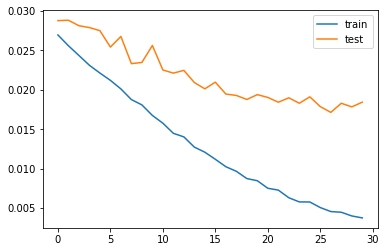

In [15]:
plt.plot(epoch_train_loss, label='train')
plt.plot(epoch_test_loss, label='test')
plt.legend();

In [16]:
train_targets, train_preds, train_loss = loop(train_loader)
accuracy_score(train_targets, train_preds.round())

0.99722799722799726

In [17]:
log_loss(train_targets, train_preds)

0.07909667784946732

In [18]:
test_targets, test_preds, test_loss = loop(test_loader)
accuracy_score(test_targets, test_preds.round())

0.77639751552795033

In [19]:
log_loss(test_targets, test_preds)

0.43016739653004993

In [20]:
icebergs_test = load_test_set()

In [21]:
def predict_testset(icebergs_test):
    scalert_1 = StandardScaler()
    scalert_2 = StandardScaler()

    for _, i in icebergs_test.iterrows():
        scalert_1.partial_fit(i.band_1.reshape(1, -1))
        scalert_2.partial_fit(i.band_2.reshape(1, -1))

    testset_x = tensorify(scalert_1.transform(np.stack(icebergs_test.band_1)))
    testset_y = torch.from_numpy(np.zeros(len(testset_x))).long()

    testset_loader = data_utils.DataLoader(data_utils.TensorDataset(testset_x, testset_y), batch_size=batch_size, shuffle=False)

    testset_targets, testset_preds, testset_loss = loop(testset_loader, training=False)
    
    icebergs_test['is_iceberg'] = testset_preds
    
    icebergs_test[['is_iceberg']].to_csv('data/submission.csv')
    
    return testset_targets, testset_preds, testset_loss